In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor


In [25]:
Xtr_raw = pd.read_csv("dengue_features_train.csv")
ytr_raw = pd.read_csv("dengue_labels_train.csv")
Xte_raw = pd.read_csv("dengue_features_test.csv")
sub = pd.read_csv("submission_format.csv")

In [26]:
for df in [Xtr_raw, Xte_raw]:
    df["sin_week"] = np.sin(2*np.pi*df["weekofyear"]/52)
    df["cos_week"] = np.cos(2*np.pi*df["weekofyear"]/52)

for df in [Xtr_raw, Xte_raw]:
    df.sort_values(["city","year","weekofyear"], inplace=True)
    num_cols = df.select_dtypes(include=["number"]).columns
    for city in df["city"].unique():
        idx = df["city"] == city
        df.loc[idx, num_cols] = df.loc[idx, num_cols].interpolate(method="linear", limit_direction="both")

In [27]:
train_df = Xtr_raw.merge(ytr_raw, on=["city","year","weekofyear"])
train_df.sort_values(["city","year","weekofyear"], inplace=True)
train_df.reset_index(drop=True, inplace=True)

In [28]:
for l in [1,2,3,4]:
    train_df[f"total_cases_lag_{l}"] = train_df.groupby("city")["total_cases"].shift(l)

train_df["total_cases_roll_mean_4"] = (
    train_df.groupby("city")["total_cases"].shift(1).rolling(4).mean()
    .reset_index(level=0, drop=True)
)
train_df["total_cases_roll_std_4"] = (
    train_df.groupby("city")["total_cases"].shift(1).rolling(4).std()
    .reset_index(level=0, drop=True)
)

In [29]:
train_df["reanalysis_avg_temp_k_lag_1"] = train_df.groupby("city")["reanalysis_avg_temp_k"].shift(1)
train_df["precipitation_amt_mm_lag_1"]  = train_df.groupby("city")["precipitation_amt_mm"].shift(1)

train_df["temp_roll_mean_4"] = (
    train_df.groupby("city")["reanalysis_avg_temp_k"].rolling(4, min_periods=1).mean()
    .reset_index(level=0, drop=True)
)
train_df["precip_roll_sum_4"] = (
    train_df.groupby("city")["precipitation_amt_mm"].rolling(4, min_periods=1).sum()
    .reset_index(level=0, drop=True)
)

train_df["temp_roll_mean_53"] = (
    train_df.groupby("city")["reanalysis_avg_temp_k"].rolling(53, min_periods=1).mean()
    .reset_index(level=0, drop=True)
)
train_df["precip_roll_sum_53"] = (
    train_df.groupby("city")["precipitation_amt_mm"].rolling(53, min_periods=1).sum()
    .reset_index(level=0, drop=True)
)
train_df["humidity_roll_mean_53"] = (
    train_df.groupby("city")["reanalysis_relative_humidity_percent"].rolling(53, min_periods=1).mean()
    .reset_index(level=0, drop=True)
)

In [30]:
Xte = Xte_raw.copy()
Xte.sort_values(["city","year","weekofyear"], inplace=True)
Xte.reset_index(drop=True, inplace=True)

Xte_parts = []
for city in ["sj","iq"]:
    trc = Xtr_raw[Xtr_raw["city"]==city].sort_values(["year","weekofyear"]).copy()
    tec = Xte[Xte["city"]==city].sort_values(["year","weekofyear"]).copy().reset_index(drop=True)

    seed4 = trc.tail(3)[["reanalysis_avg_temp_k","precipitation_amt_mm"]].copy()
    combo4 = pd.concat([seed4, tec[["reanalysis_avg_temp_k","precipitation_amt_mm"]]], ignore_index=True)
    tec["temp_roll_mean_4"]  = combo4["reanalysis_avg_temp_k"].rolling(4, min_periods=1).mean().iloc[len(seed4):].reset_index(drop=True)
    tec["precip_roll_sum_4"] = combo4["precipitation_amt_mm"].rolling(4, min_periods=1).sum().iloc[len(seed4):].reset_index(drop=True)

    seed53 = trc.tail(52)[["reanalysis_avg_temp_k","precipitation_amt_mm","reanalysis_relative_humidity_percent"]].copy()
    combo53 = pd.concat([seed53, tec[["reanalysis_avg_temp_k","precipitation_amt_mm","reanalysis_relative_humidity_percent"]]], ignore_index=True)

    tec["temp_roll_mean_53"]  = combo53["reanalysis_avg_temp_k"].rolling(53, min_periods=1).mean().iloc[len(seed53):].reset_index(drop=True)
    tec["precip_roll_sum_53"] = combo53["precipitation_amt_mm"].rolling(53, min_periods=1).sum().iloc[len(seed53):].reset_index(drop=True)
    tec["humidity_roll_mean_53"] = combo53["reanalysis_relative_humidity_percent"].rolling(53, min_periods=1).mean().iloc[len(seed53):].reset_index(drop=True)

    Xte_parts.append(tec)

Xte_feat = pd.concat(Xte_parts, ignore_index=True).sort_values(["city","year","weekofyear"]).reset_index(drop=True)



In [31]:
BASE_FEATURES = [
    "year","sin_week","cos_week",
    "ndvi_ne","ndvi_nw","ndvi_se","ndvi_sw",
    "precipitation_amt_mm","reanalysis_precip_amt_kg_per_m2",
    "reanalysis_sat_precip_amt_mm","station_precip_mm",
    "reanalysis_air_temp_k","reanalysis_avg_temp_k",
    "reanalysis_min_air_temp_k","reanalysis_max_air_temp_k",
    "station_avg_temp_c","station_min_temp_c","station_max_temp_c",
    "reanalysis_relative_humidity_percent",
    "reanalysis_specific_humidity_g_per_kg",
    "reanalysis_dew_point_temp_k",
    "reanalysis_tdtr_k","station_diur_temp_rng_c",
]

TARGET_LAG_ROLL = [
    "total_cases_lag_1","total_cases_lag_2","total_cases_lag_3","total_cases_lag_4",
    "total_cases_roll_mean_4","total_cases_roll_std_4",
]
ENV_LAG = ["reanalysis_avg_temp_k_lag_1","precipitation_amt_mm_lag_1"]
ENV_ROLL = [
    "temp_roll_mean_4","precip_roll_sum_4",
    "temp_roll_mean_53","precip_roll_sum_53","humidity_roll_mean_53"
]

FEATURES = BASE_FEATURES + TARGET_LAG_ROLL + ENV_LAG + ENV_ROLL
TARGET = "total_cases"

In [ ]:
models = {}
report = []

for city in ["sj","iq"]:
    cdf = train_df[train_df["city"]==city].copy()
    cdf = cdf.dropna(subset=TARGET_LAG_ROLL + [TARGET]).sort_values(["year","weekofyear"]).reset_index(drop=True)

    n = len(cdf)
    cut = int(0.8*n)
    tr = cdf.iloc[:cut]
    va = cdf.iloc[cut:]

    Xtr = tr[FEATURES].apply(pd.to_numeric, errors="coerce").astype(float)
    ytr = tr[TARGET].astype(float)

    Xva = va[FEATURES].apply(pd.to_numeric, errors="coerce").astype(float)
    yva = va[TARGET].astype(float)

    Xtr = Xtr.fillna(Xtr.mean())
    Xva = Xva.fillna(Xtr.mean())

    model = XGBRegressor(
        n_estimators=1500, learning_rate=0.03,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        min_child_weight=3, reg_lambda=1.0,
        objective="reg:squarederror",
    )
    model.fit(Xtr, ytr)
    

    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)

    models[city] = model
    report.append({"city": city, "MAE": mae, "n_train": len(tr), "n_val": len(va)})

print(pd.DataFrame(report))


  city       MAE  n_train  n_val
0   sj  7.265921      745    187
1   iq  7.115772      412    104


In [33]:
pred_parts = []

train_full = Xtr_raw.merge(ytr_raw, on=["city","year","weekofyear"]).sort_values(["city","year","weekofyear"])

for city in ["sj","iq"]:
    model = models[city]

    trc = train_full[train_full["city"]==city].copy()
    tec = Xte_feat[Xte_feat["city"]==city].sort_values(["year","weekofyear"]).reset_index(drop=True).copy()

    last_temp = float(trc["reanalysis_avg_temp_k"].iloc[-1])
    last_prec = float(trc["precipitation_amt_mm"].iloc[-1])

    history = trc["total_cases"].astype(float).tolist()
    yhat_list = []

    for i in range(len(tec)):
        row = tec.loc[i].copy()

        row["total_cases_lag_1"] = history[-1]
        row["total_cases_lag_2"] = history[-2]
        row["total_cases_lag_3"] = history[-3]
        row["total_cases_lag_4"] = history[-4]
        row["total_cases_roll_mean_4"] = float(np.mean(history[-4:]))
        row["total_cases_roll_std_4"]  = float(np.std(history[-4:], ddof=1)) if len(history[-4:]) >= 2 else 0.0

        if i == 0:
            row["reanalysis_avg_temp_k_lag_1"] = last_temp
            row["precipitation_amt_mm_lag_1"]  = last_prec
        else:
            row["reanalysis_avg_temp_k_lag_1"] = float(tec.loc[i-1, "reanalysis_avg_temp_k"])
            row["precipitation_amt_mm_lag_1"]  = float(tec.loc[i-1, "precipitation_amt_mm"])

        Xrow = pd.DataFrame([{k: row[k] for k in FEATURES}])
        Xrow = Xrow.apply(pd.to_numeric, errors="coerce").astype(float).fillna(0.0)

        yhat = float(model.predict(Xrow)[0])
        yhat = max(0.0, yhat)

        yhat_list.append(yhat)
        history.append(yhat)

    out = tec[["city","year","weekofyear"]].copy()
    out["total_cases"] = np.round(yhat_list).astype(int)
    pred_parts.append(out)

pred_df = pd.concat(pred_parts, ignore_index=True)



In [34]:
sub2 = sub.drop(columns=["total_cases"]).merge(pred_df, on=["city","year","weekofyear"], how="left")
sub2["total_cases"] = sub2["total_cases"].fillna(0).clip(lower=0).astype(int)
sub2.to_csv("submission_model2_xgb.csv", index=False)

print(sub2.head())


  city  year  weekofyear  total_cases
0   sj  2008          18            7
1   sj  2008          19            8
2   sj  2008          20            9
3   sj  2008          21            9
4   sj  2008          22            7


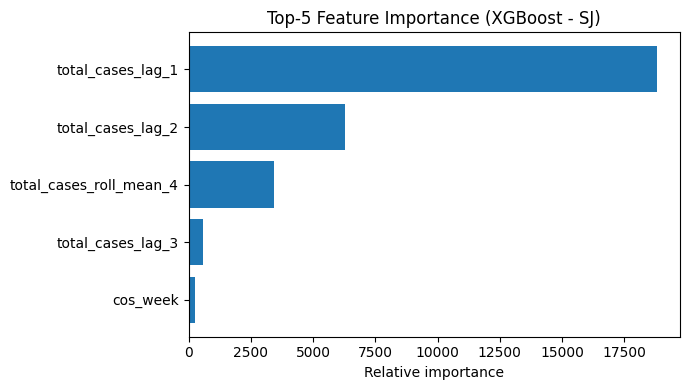

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

city = "sj"
model = models[city]
booster = model.get_booster()

imp = booster.get_score(importance_type="gain")
imp_df = (pd.DataFrame({"feature": imp.keys(), "importance": imp.values()})
          .sort_values("importance", ascending=False)
          .head(5))

plt.figure(figsize=(7,4))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Relative importance")
plt.title("Top-5 Feature Importance (XGBoost - SJ)")
plt.tight_layout()
plt.show()


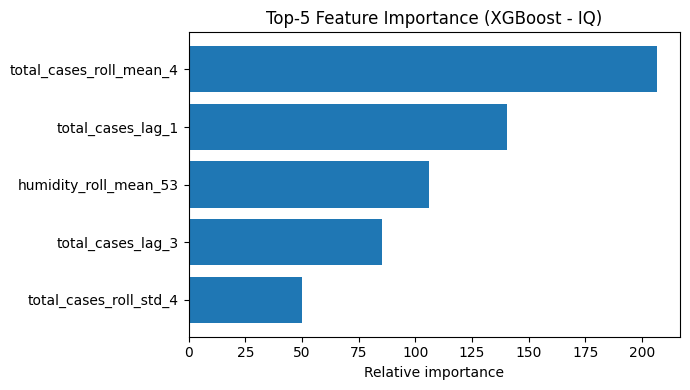

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

city = "iq"
model = models[city]
booster = model.get_booster()

imp = booster.get_score(importance_type="gain")
imp_df = (pd.DataFrame({"feature": imp.keys(), "importance": imp.values()})
          .sort_values("importance", ascending=False)
          .head(5))

plt.figure(figsize=(7,4))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Relative importance")
plt.title("Top-5 Feature Importance (XGBoost - IQ)")
plt.tight_layout()
plt.show()
